In [1]:
# This is a Python 3 script

In [29]:
# Format code for fortran code: FORMAT(I4,F10.3,F10.3)
def ConstructInputASURV(fitting_table, line1, line2, outdir, obj=None):
    from astropy.io import ascii
    import numpy as np

    data = ascii.read(fitting_table)
    
    # get line fitting results of a single object if specified
    if obj != None:
        data = data[data['Object'] == obj]
    
    
    # Restrict to only select the 1-D spectra
    data = data[data['Pixel_No.'] == 'c']
    
    data1 = data[data['Line'] == line1]
    data2 = data[data['Line'] == line2]
    
    # make sure the objects have both PACS and SPIRE data
    data1_filter = np.zeros_like(data1['Validity'].data, dtype='bool')
    for i in range(len(data1)):
        if data1['Object'][i] in data2['Object'].data:
            data1_filter[i] = True

    data2_filter = np.zeros_like(data2['Validity'].data, dtype='bool')
    for i in range(len(data2)):
        if data2['Object'][i] in data1['Object'].data:
            data2_filter[i] = True
    
    data1 = data1[data1_filter]
    data2 = data2[data2_filter]
    
    # replace the non-detection to upper limit
    def FindUpperLimit(table):
        upperlimit_flag = np.empty_like(table['Str(W/cm2)'].data, dtype=int)
        linestr = np.empty_like(table['Str(W/cm2)'].data, dtype=float)
        linestr_unc = np.empty_like(table['Str(W/cm2)'].data, dtype=float)
        
        for i in range(len(table)):
            # for line fluxes with SNR < 3 or not able to fit properly
            # determine the SNR threshold based on modules (PACS or SPIRE)
            if table['ObsWL(um)'][i].astype('float') >= 196:
                snr_threshold = 4.0
#                 print('Customized SNR threshold is used')
            else:
                snr_threshold = 3.0
            if (table['Validity'][i].astype('float') == '0') or (table['SNR'][i].astype('float') < snr_threshold):
                upperlimit_flag[i] = -1
                linestr[i] = table['Noise(W/cm2/um)'][i].astype('float')*table['FWHM(um)'][i].astype('float')*1.064*3
                linestr_unc[i] = -1
            else:
                upperlimit_flag[i] = 0
                linestr[i] = table['Str(W/cm2)'][i].astype('float')
                linestr_unc[i] = table['Sig_str(W/cm2)'][i].astype('float')
            
        # convert the flux unit from W/cm2 to W/m2
        linestr = linestr*1e4
        linestr_unc[linestr_unc != -1] = linestr_unc[linestr_unc != -1]*1e4
        
        return upperlimit_flag, linestr, linestr_unc

    ulf1, linestr1, linestr_unc1 = FindUpperLimit(data1)
    ulf2, linestr2, linestr_unc2 = FindUpperLimit(data2)
    
    # check size
    if len(linestr1) != len(linestr2):
        print('The sizes of two arrays are inconsistent.')
        return None
    
#     For bivariate data:

#     3 : Both Independent and Dependent Variables are Lower Limits
#     2 : Only independent Variable is a Lower Limit
#     1 : Only Dependent Variable is a Lower Limit
#     0 : Detected Point
#     -1 : Only Dependent Variable is an Upper Limit
#     -2 : Only Independent Variable is an Upper Limit
#     -3 : Both Independent and Dependent Variables are Upper Limits

    # Define data1 as the independent variable, and data2 as the dependent variable.
    ulf1 = ulf1*2
    ulf = ulf1+ulf2
    
    # writing out
    foo = open(outdir+'co.dat', 'w')
#     foo.write('# '+line1+' and '+line2+'\n')
#     foo.write('# flux in 10^-18 W/m2 unit. \n')
    for i in range(len(linestr1)):
        foo.write('{:>4d}{:>10.3e}{:>10.3e} \n'.format(ulf[i], linestr1[i], linestr2[i]))
    foo.close()
    
    # if no detection found, throw a flag
    flag = True
    if not 0 in ulf:
        flag = False
    return flag

In [30]:
def RunandParseASURV(code_dir, outdir):
    import os
    import subprocess
    import sys
    
    ON_POSIX = 'posix' in sys.builtin_module_names
    # claer out previous output to prevent seg fault
    if os.path.exists(code_dir+'co.out'):
        os.remove(code_dir+'co.out')

#     p = subprocess.call([code_dir+'asurv_code'])
    p = subprocess.Popen([code_dir+'asurv_code_static'], stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, bufsize=1, close_fds=ON_POSIX)
#     p.communicate()
    print(p.stdout.readlines()[-1])
    print(p.stderr.readlines())
    
    out = open(code_dir+'co.out', 'r').read().splitlines()

    # [print(line) for line in out]

    # find the result about generalized Kendall's Tau, and Spearman's Rho
    for line in out:
        if 'Z-VALUE' in line:
            tau_i = out.index(line)
        if 'SPEARMANS RHO =' in line:
            spear_rho = out.index(line)
    
    kendall = (float(out[tau_i].split('=')[-1].strip()), float(out[tau_i+1].split('=')[-1].strip()))
    spearman = (float(out[spear_rho].split('=')[-1].strip()), float(out[spear_rho+1].split(' ')[12]))
    line1, line2 = out[8].split('AND')[0].strip(), out[8].split('AND')[1].strip()
#     print(kendall, spearman)
#     os.rename(code_dir+'co.out', outdir+line1+'_'+line2+'.out')
#     os.remove(code_dir+'co.out')

    return kendall, spearman


## Single line pair test

In [31]:
fitting_table = '/Volumes/SD-Mac/CDF_archive_v2/CDF_archive_v2_lines.txt'
# fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
line1 = 'CO5-4'
line2 = 'CO36-35'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
ConstructInputASURV(fitting_table, line1, line2, outdir)
k, s = RunandParseASURV(code_dir, outdir)
print(k,s)

b'                           PROBLEMS ARE FINISHED\n'
[]
(2.365, 0.018027) (0.319, 0.1642)


In [13]:
import numpy as np
(-2*np.log(s[1]))**0.5

4.3688402346980437

## Plot the line fluxes of a given line pair

[None, None, None, None]

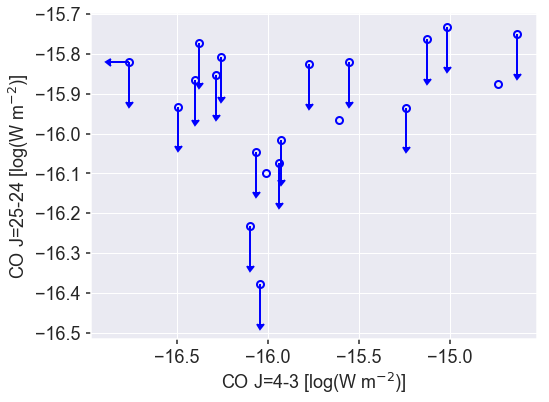

In [32]:
%matplotlib inline
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import ascii
data = ascii.read(outdir+'co.dat', names=['ufl', line1, line2])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.log10(data[line1][data['ufl'] == 0]), np.log10(data[line2][data['ufl'] == 0]), 'o',   mec='b', mfc='None',
         markeredgewidth=2)
# upper limit on x-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -2]), np.log10(data[line2][data['ufl'] == -2]),
             xerr=np.array([0.1]*len(data[line1][data['ufl'] == -2])), xuplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
# # upper limit on y-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -1]), np.log10(data[line2][data['ufl'] == -1]),
             yerr=np.array([0.1]*len(data[line1][data['ufl'] == -1])), uplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
# upper limit on both x-axis and y-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -3]), np.log10(data[line2][data['ufl'] == -3]),
             xerr=np.array([0.1]*len(data[line1][data['ufl'] == -3])), 
             yerr=np.array([0.1]*len(data[line1][data['ufl'] == -3])),
             xuplims=True, uplims=True, fmt='o', mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
ax.set_xlabel('CO J=4-3 [log(W m$^{-2}$)]', fontsize=18)
ax.set_ylabel('CO J=25-24 [log(W m$^{-2}$)]', fontsize=18)
ax.tick_params('both',labelsize=16,which='major')
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=5,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=5,length=2.5)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]

# fig.savefig('/Users/yaolun/test/CO43_CO2524.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Run all CO line pairs

In [ ]:
import itertools
from astropy.io import ascii
import numpy as np

# fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))

co_list = co_list

# print(list(itertools.combinations(co_list, 2)))

co_pair_list = list(itertools.combinations_with_replacement(co_list, 2))
print(len(co_pair_list))

foo = open(outdir+'co_correlation.txt', 'w')
foo.write('{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}\n'.format('Line1','Line2','Ken.z','Ken.prob','Spr.rho','Spr.prob'))

for pair in co_pair_list:
    line1 = pair[0]
    line2 = pair[1]
    
#     print(line1, line2)
    
    flag = ConstructInputASURV(fitting_table, line1, line2, outdir)
    if flag:
        k, s = RunandParseASURV(code_dir, outdir)
#         print(line1+'/'+line2, k, s)
    
        foo.write('{:<10s}{:<10s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,k[0],k[1],s[0],s[1]))
    else:
        foo.write('{:<10s}{:<10s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,0,0,0,0))
    
foo.close()

## Use Pandas and Seaborn to visualize the results

In [28]:
%matplotlib inline

In [ ]:
def co_heatmap(col_name, fitting_table, label):
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # create data 2d array
    j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])

    # j_up = j_up[:5]
    j_up = j_up[j_up <= 36]
    data = np.empty((len(j_up), len(j_up)))

    # read in the result
    table = ascii.read(outdir+'co_correlation.txt')

    for i in range(len(j_up)):
        for j in range(i, len(j_up)):
            selector1 = (table['Line1'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                        (table['Line2'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
            selector2 = (table['Line2'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                        (table['Line1'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
            selector = selector1 + selector2

            if not (table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector] == 0:
                data[i,j] = table[col_name][selector]
                data[j,i] = table[col_name][selector]
            else:
                data[i,j] = np.nan
                data[j,i] = np.nan


    # construct Pandas DataFrame
    data = data[::-1,:]
    # dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
    line_list = ['CO J='+str(j_up[i])+'-'+str(j_up[i]-1) for i in range(len(j_up))]
    dataset = pd.DataFrame(data=data, index=line_list[::-1], columns=line_list)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if col_name == 'Ken.z':
        vmax = 7.0
    else:
        vmax = None
    
    sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax)
    cax.set_ylabel(label, fontsize=18)

    ax.set_xlabel('J$_{up}$', fontsize=18)
    ax.set_ylabel('J$_{up}$', fontsize=18)

    fig.savefig('/Users/yaolun/test/co_heatmap_'+col_name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']
diag_value = [np.nan,0,1,0]
labels = ['Kendall z-value','Kendall probability',r'Spearman$\prime s\,\rho$',r'Spearman$\prime s$ probability']
fitting_table = outdir+'co_correlation.txt'
outdir = '/Users/yaolun/astro_tools/'

for i in range(len(col_name)):
    co_heatmap(col_name[i], fitting_table, labels[i])

## Run all line pairs

In [4]:
import itertools
from astropy.io import ascii
import numpy as np

# fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))

line_list = np.hstack((co_list,np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
                                         'p-H2O1_11-0_00','o-H2O1_10-1_01','o-H2O3_12-2_21','p-H2O2_02-1_11',
                                         'o-H2O3_03-2_12','o-H2O2_12-1_01',
                                         'p-H2O3_13-2_02','o-H2O3_30-2_21',
                                         'p-H2O3_31-2_20','OI3P1-3P2','CI3P1-3P0','CI3P2-3P1',
                                         'OH2-0','OH3-1','HCO+7-6'])))

# print(list(itertools.combinations(co_list, 2)))

pair_list = list(itertools.combinations_with_replacement(line_list, 2))
print(len(pair_list))

foo = open(outdir+'all_correlation.txt', 'w')
foo.write('{:<16s}{:<16s}{:<10s}{:<10s}{:<10s}{:<10s}\n'.format('Line1','Line2','Ken.z','Ken.prob','Spr.rho','Spr.prob'))

for pair in pair_list:
    line1 = pair[0]
    line2 = pair[1]
    
#     print(line1, line2)
    
    flag = ConstructInputASURV(fitting_table, line1, line2, outdir)
    if flag:
        k, s = RunandParseASURV(code_dir, outdir)
#         print(line1+'/'+line2, k, s)
    
        foo.write('{:<16s}{:<16s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,k[0],k[1],s[0],s[1]))
    else:
        foo.write('{:<16s}{:<16s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,0,0,0,0))
    
foo.close()

1953
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                        

In [5]:
from astropy.io import ascii
table = ascii.read(outdir+'all_correlation.txt')
print(table['Spr.rho'].min())
print(table['Line1'][table['Spr.rho'] < 0])
print(table['Line2'][table['Spr.rho'] < 0])

-0.242
 Line1 
-------
CO14-13
CO37-36
CO37-36
CO37-36
CO39-38
CO39-38
CO39-38
CO39-38
CO39-38
CO39-38
    Line2     
--------------
       CO39-38
         CO4-3
o-H2O3_03-2_12
o-H2O2_12-1_01
         CO4-3
         CO5-4
p-H2O2_02-1_11
o-H2O3_03-2_12
o-H2O2_12-1_01
p-H2O3_13-2_02


In [ ]:
def general_heatmap(line_list, col_name, fitting_table, label, mod_name='', line_labels=None, suffix=''):
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib import colors


    # set the colormap and centre the colorbar
    class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
    # read in the result
    table = ascii.read(outdir+'all_correlation.txt')

    data = np.empty((len(line_list), len(line_list)))
    
    for i in range(len(line_list)):
        for j in range(i, len(line_list)):
            selector1 = (table['Line1'] == line_list[i]) & \
                        (table['Line2'] == line_list[j])
            selector2 = (table['Line2'] == line_list[i]) & \
                        (table['Line1'] == line_list[j])
            selector = selector1 + selector2

            if not len((table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector]) == 0:
                data[i,j] = table[col_name][selector]
                data[j,i] = table[col_name][selector]
            else:
                data[i,j] = np.nan
                data[j,i] = np.nan

    
    # if there is no line name labels given, use the line list name instead
    if line_labels is None:
        line_labels = line_list
                

    # construct Pandas DataFrame
    data = data[::-1,:]
    # dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
    dataset = pd.DataFrame(data=data, index=line_labels[::-1], columns=line_labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cmap = "cubehelix"
    
    if col_name == 'Ken.z':
        vmax = 6.0
        vmin = 0.0
        cmap = 'RdGy_r'
#         sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax,
#                     norm=MidpointNormalize(midpoint=3,vmin=vmin, vmax=vmax), cmap=cmap)
        sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
                vmin=vmin, cmap=cmap)
        
    elif col_name =='Spr.rho':
        dataset = ((20-3)/1.06)**0.5*0.5*np.log((1+dataset)/(1-dataset))
        print(dataset.max())
        vmax = 8.0
        vmin = 0.0
        cmap = 'RdGy_r'
#         sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax,
#                     norm=MidpointNormalize(midpoint=3.0,vmin=vmin, vmax=vmax), cmap=cmap)
        sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
                vmin=vmin, cmap=cmap)
    else:
        # calculate the cooresponding sigma level assuming a normal distribution
        dataset = dataset.replace(0.0, 1.0)
        dataset = (-2*np.log(dataset))**0.5
        vmax = 8
        vmin = 0
        sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
                vmin=vmin, cmap=cmap)

    
    cax.set_ylabel(label, fontsize=26, labelpad=10)
    cax.tick_params('both',labelsize=20)
    cax.minorticks_on()

    ax.tick_params('both',labelsize=20)
    
    # if only plot CO lines, color the tick labels based on the instrument
    if 'co' in suffix:
        color_list = ['k','r','b','b','k']
        # x-axis
        for i in range(len(ax.get_xticklabels())):
            if i <= 4:
                ax.get_xticklabels()[i].set_color(color_list[0])
            elif (i > 4) & (i <= 9):
                ax.get_xticklabels()[i].set_color(color_list[1])
            elif (i > 9) & (i <= 13):
                ax.get_xticklabels()[i].set_color(color_list[2])
            elif (i > 13) & (i <= 21):
                ax.get_xticklabels()[i].set_color(color_list[3])
            else:
                ax.get_xticklabels()[i].set_color(color_list[4])
        
        # y-axis
        for i in range(len(ax.get_yticklabels())):
            if i <= 4:
                ax.get_yticklabels()[i].set_color(color_list[0])
            elif (i > 4) & (i <= 9):
                ax.get_yticklabels()[i].set_color(color_list[1])
            elif (i > 9) & (i <= 13):
                ax.get_yticklabels()[i].set_color(color_list[2])
            elif (i > 13) & (i <= 21):
                ax.get_yticklabels()[i].set_color(color_list[3])
            else:
                ax.get_yticklabels()[i].set_color(color_list[4])

    if mod_name != '':
        mod_name = '_'+mod_name
    fig.savefig('/Users/yaolun/test/general_heatmap_'+col_name.replace('.','_')+mod_name+suffix+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

## only plot the lines reside in the same module

In [36]:
from astropy.io import ascii
import numpy as np                  

col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']

labels = ['Kendall z-value','Kendall probability',r'Spearman$\prime s\,\rho$',r'Spearman$\prime s$ probability']
outdir = '/Users/yaolun/astro_tools/'
corr_table = outdir+'all_correlation.txt'

fitting_table = '/Volumes/SD-Mac/CDF_archive_v2/CDF_archive_v2_lines.txt'
# fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'

# construct the line list
data = ascii.read(fitting_table)
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data['Line'].data)))))
j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])  
line_list_co = ['CO'+str(j_up[i])+'-'+str(j_up[i]-1) for i in range(len(j_up[j_up <= 36]))]
line_list_co.remove('CO33-32')
line_list_co.remove('CO31-30')
line_list = np.hstack((np.array(line_list_co),np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
                            'p-H2O1_11-0_00','o-H2O3_12-2_21','p-H2O2_02-1_11',
                            'o-H2O3_03-2_12','o-H2O2_12-1_01',
                            'p-H2O3_13-2_02','o-H2O3_30-2_21',
                            'p-H2O3_31-2_20','OI3P1-3P2','CI3P1-3P0','CI3P2-3P1',
                            'OH2-0','OH3-1','HCO+7-6'])))
# line_list = np.hstack((np.array(line_list_co),np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
#                             'o-H2O3_03-2_12','o-H2O2_12-1_01','p-H2O3_13-2_02','p-H2O2_02-1_11','p-H2O1_11-0_00',
#                             'o-H2O3_30-2_21','p-H2O3_31-2_20','OI3P1-3P2','CI3P1-3P0','CI3P2-3P1',
#                             'OH2-0','OH3-1'])))

# form a proper formatted label list with mathtex
labels_co = np.empty_like(np.array(line_list_co), dtype=object)
import re
for i in range(len(line_list_co)):
    labels_co[i] = 'CO '+line_list_co[i].split('-')[0].split('CO')[1]+r'\rightarrow'+line_list_co[i].split('-')[1]
line_labels = np.hstack((labels_co, np.array([r'^{13}\rm CO\,5 \rightarrow 4',r'^{13}\rm CO\,6 \rightarrow 5',
                                        r'^{13}\rm CO\,7 \rightarrow 6',r'^{13}\rm CO\,8 \rightarrow 7',
                                        r'^{13}\rm CO\,9 \rightarrow 8',r'\rm p-H_{2}O\,1_{11} \rightarrow 0_{00}',
                                        r'\rm o-H_{2}O\,3_{12}\rightarrow 2_{21}',
                                        r'\rm p-H_{2}O\,2_{02} \rightarrow 1_{11}',r'\rm o-H_{2}O\,3_{03} \rightarrow 2_{12}',
                                        r'\rm o-H_{2}O\,2_{12} \rightarrow 1_{01}',r'\rm p-H_{2}O\,3_{13}\rightarrow 2_{02}',
                                        r'\rm o-H_{2}O\,3_{30} \rightarrow 2_{21}',r'\rm p-H_{2}O\,3_{31} \rightarrow 2_{20}',
                                        r'\rm [OI]\,^{3}P_{1} \rightarrow ^{3}P_{2}',
                                        r'\rm [CI]\,^{3}P_{1} \rightarrow ^{3}P_{0}',
                                        r'\rm [CI]\,^{3}P_{2} \rightarrow ^{3}P_{1}',
                                        r'\rm OH\,^{2}\Pi_{1/2,5/2}^{+} \rightarrow ^{2}\Pi_{3/2,3/2}^{-}',
                                        r'\rm OH\,^{2}\Pi_{3/2,5/2}^{-} \rightarrow ^{2}\Pi_{3/2,3/2}^{+}',
                                        r'\rm HCO^{+}\,7\rightarrow 6'])))


for i in range(len(line_labels)):
    line_labels[i] = r'$'+line_labels[i]+r'$'
for i in range(len(labels_co)):
    labels_co[i] = r'$'+labels_co[i]+r'$'


# get the corresponding wavelength of the line list
wave_list = np.array([float(list(set(data['LabWL(um)'][data['Line'] == line_list[i]]))[0]) for i in range(len(line_list))])

module = {'B2A': [54.8, 72.3], 'B2B': [72.3, 95.05], 'R1': [101.4, 190.31],
          'SSW': [195, 310], 'SLW': [310,680]}
%matplotlib inline

$CO 4\rightarrow3$      inf
$CO 5\rightarrow4$      inf
$CO 6\rightarrow5$      inf
$CO 7\rightarrow6$      inf
$CO 8\rightarrow7$      inf
$CO 9\rightarrow8$      inf
$CO 10\rightarrow9$     inf
$CO 11\rightarrow10$    inf
$CO 12\rightarrow11$    inf
$CO 13\rightarrow12$    inf
$CO 14\rightarrow13$    inf
$CO 15\rightarrow14$    inf
$CO 16\rightarrow15$    inf
$CO 17\rightarrow16$    inf
$CO 18\rightarrow17$    inf
$CO 19\rightarrow18$    inf
$CO 20\rightarrow19$    inf
$CO 21\rightarrow20$    inf
$CO 22\rightarrow21$    inf
$CO 23\rightarrow22$    inf
$CO 24\rightarrow23$    inf
$CO 25\rightarrow24$    inf
$CO 28\rightarrow27$    inf
$CO 29\rightarrow28$    inf
$CO 30\rightarrow29$    inf
$CO 32\rightarrow31$    inf
$CO 34\rightarrow33$    inf
$CO 35\rightarrow34$    inf
$CO 36\rightarrow35$    inf
dtype: float64


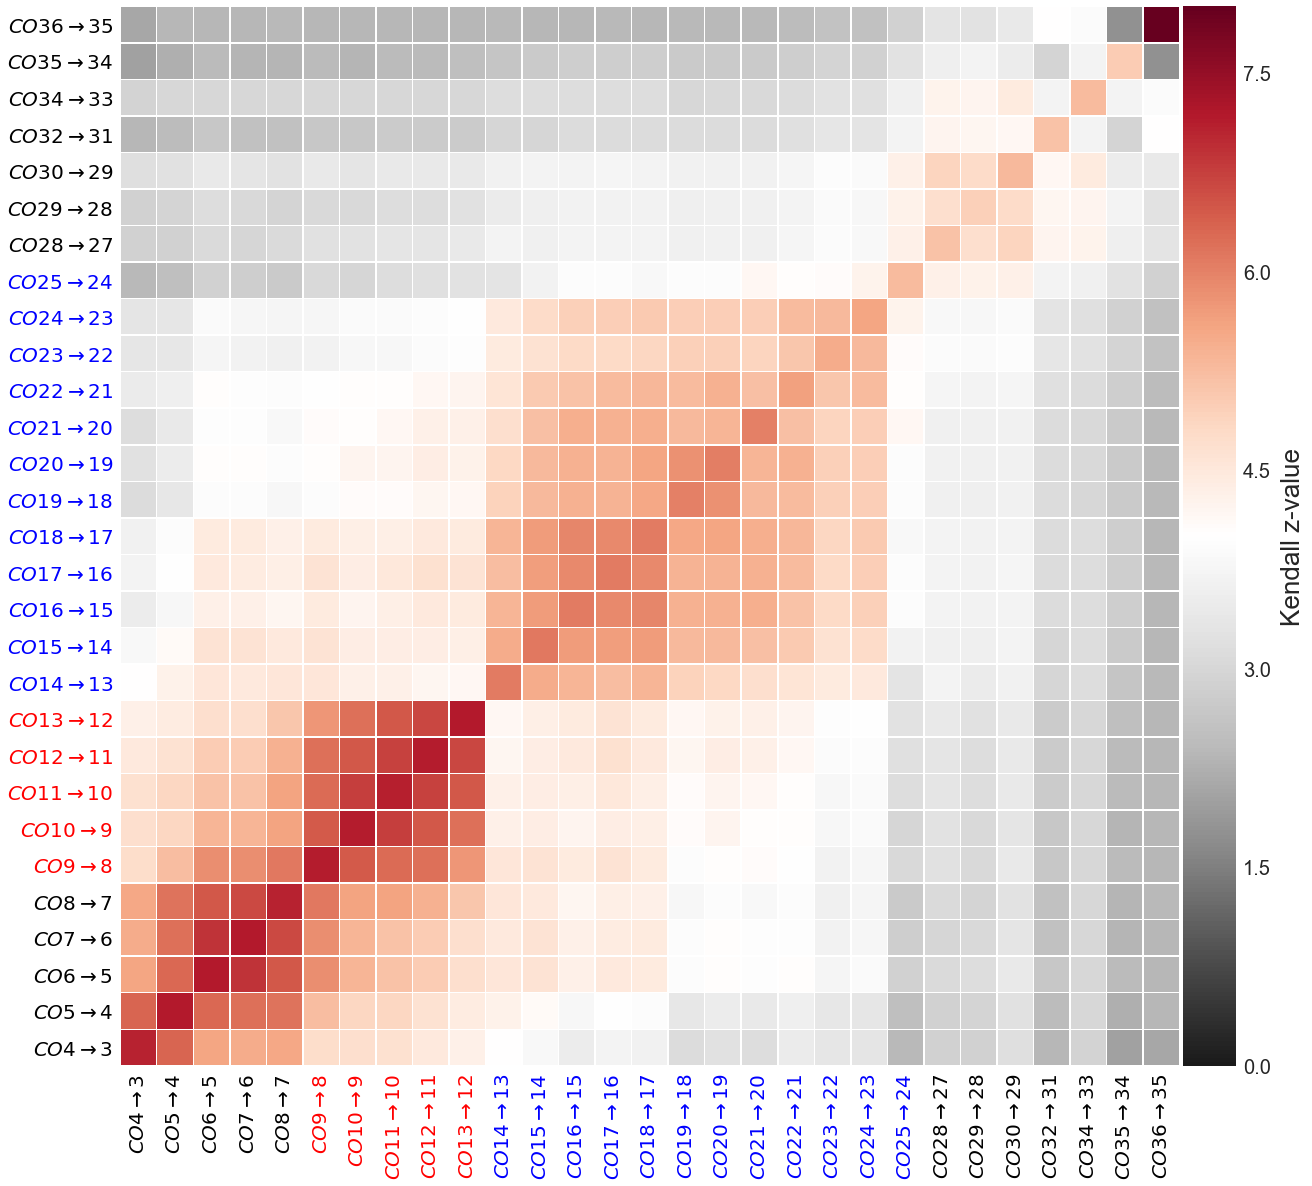

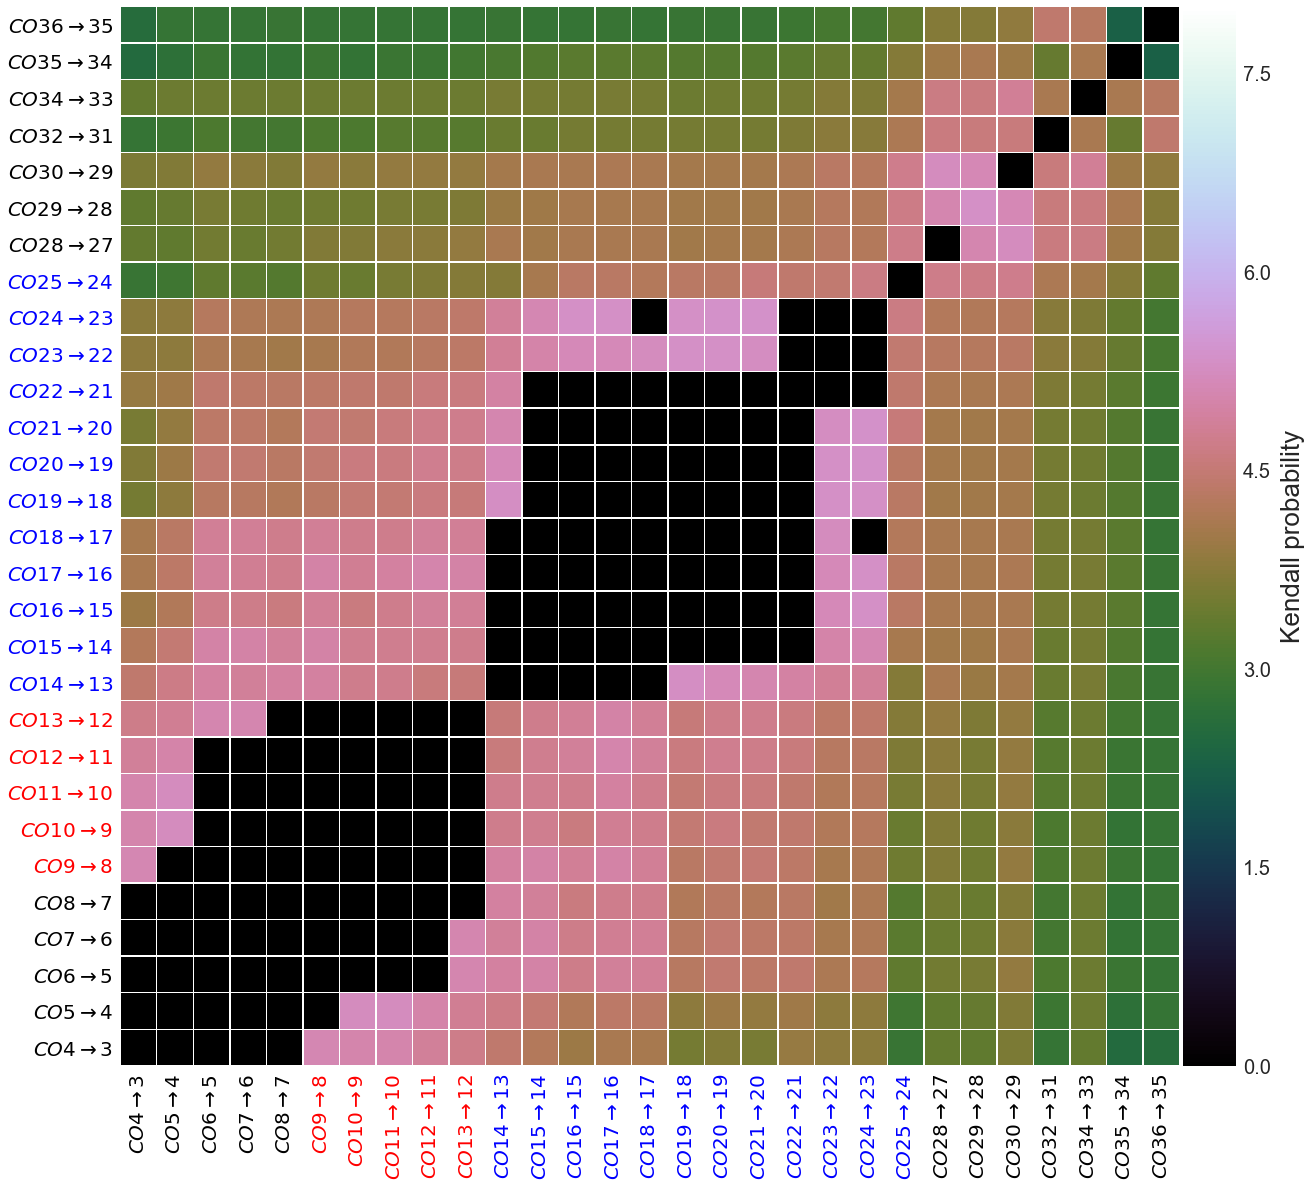

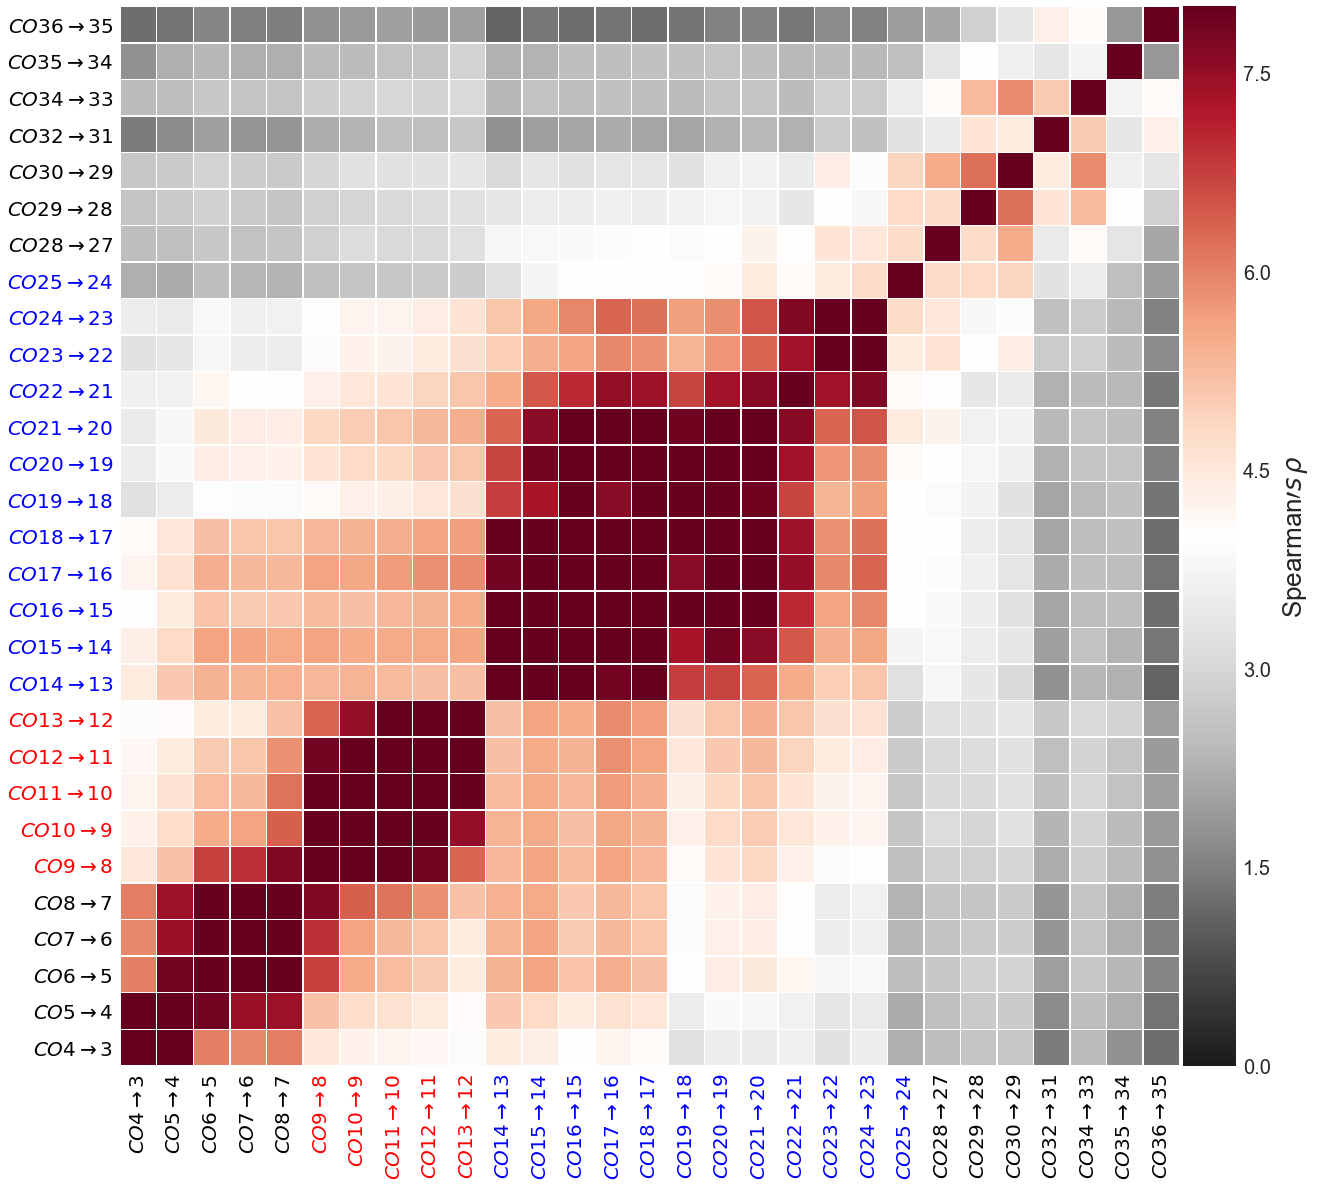

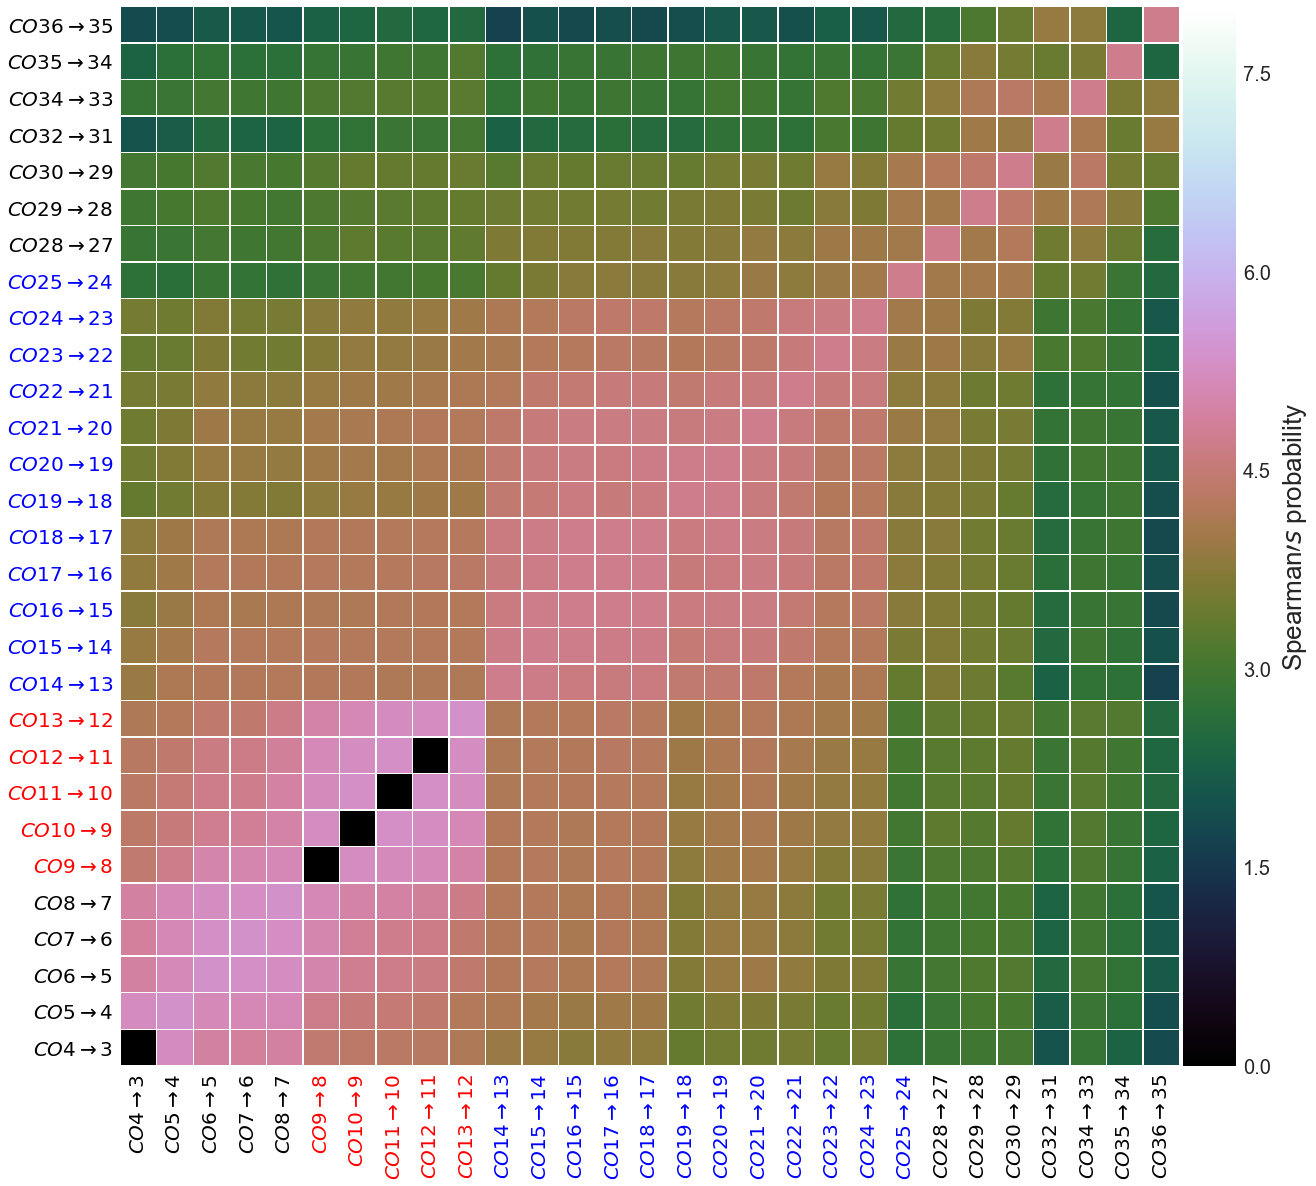

In [72]:
# only CO lines
col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']
for i in range(len(col_name)):
    general_heatmap(line_list_co, col_name[i], corr_table, labels[i], line_labels=labels_co, suffix='_co')

$CO 4\rightarrow3$                                                   inf
$CO 5\rightarrow4$                                                   inf
$CO 6\rightarrow5$                                                   inf
$CO 7\rightarrow6$                                                   inf
$CO 8\rightarrow7$                                                   inf
$CO 9\rightarrow8$                                                   inf
$CO 10\rightarrow9$                                                  inf
$CO 11\rightarrow10$                                                 inf
$CO 12\rightarrow11$                                                 inf
$CO 13\rightarrow12$                                                 inf
$CO 14\rightarrow13$                                                 inf
$CO 15\rightarrow14$                                                 inf
$CO 16\rightarrow15$                                                 inf
$CO 17\rightarrow16$                               

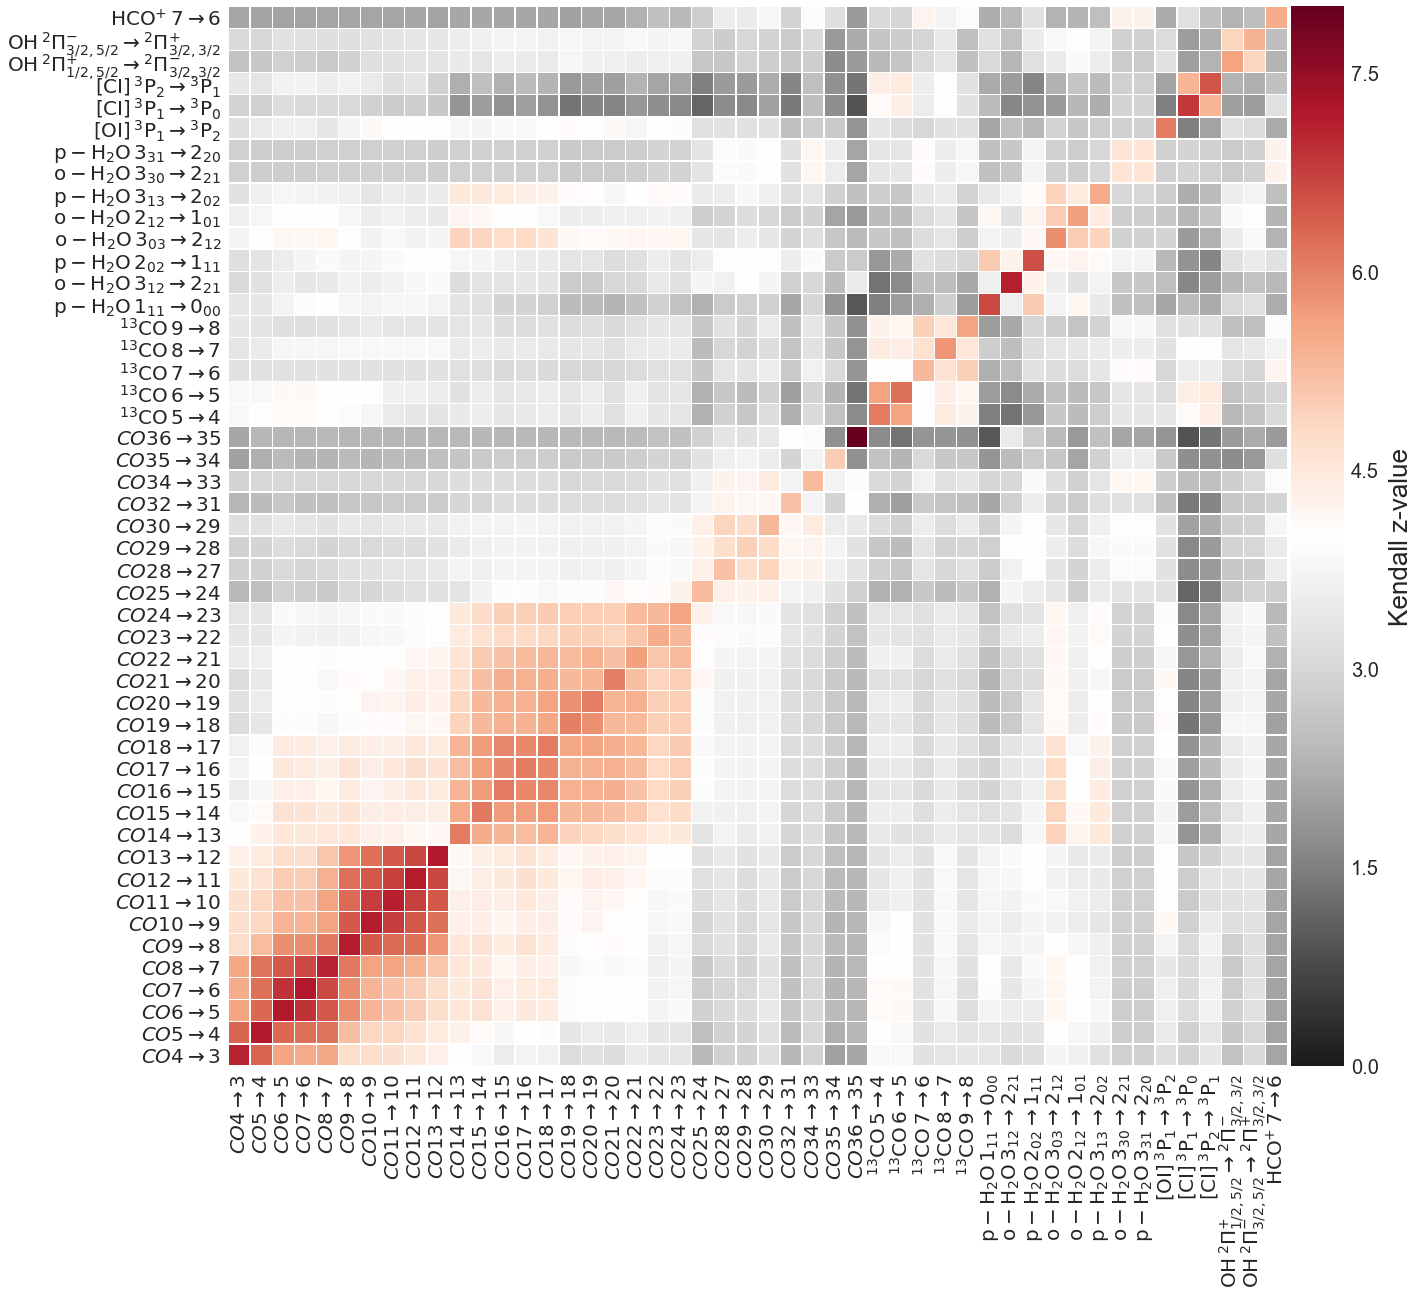

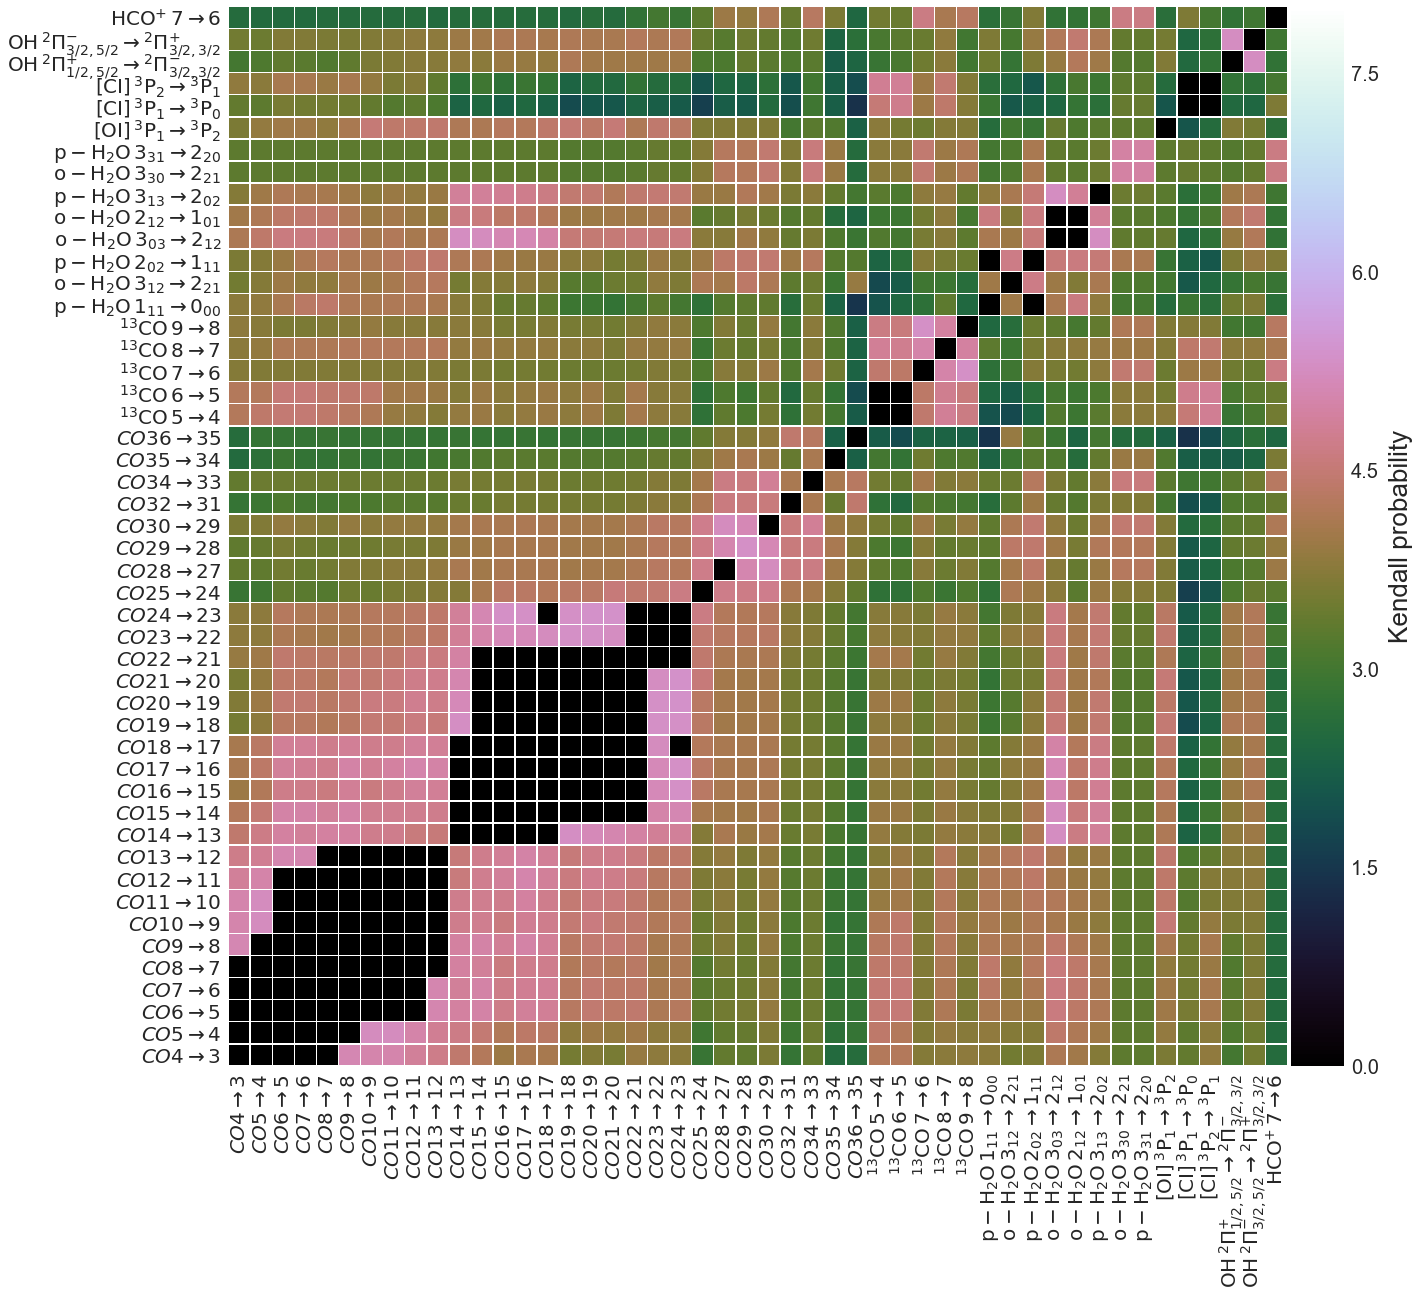

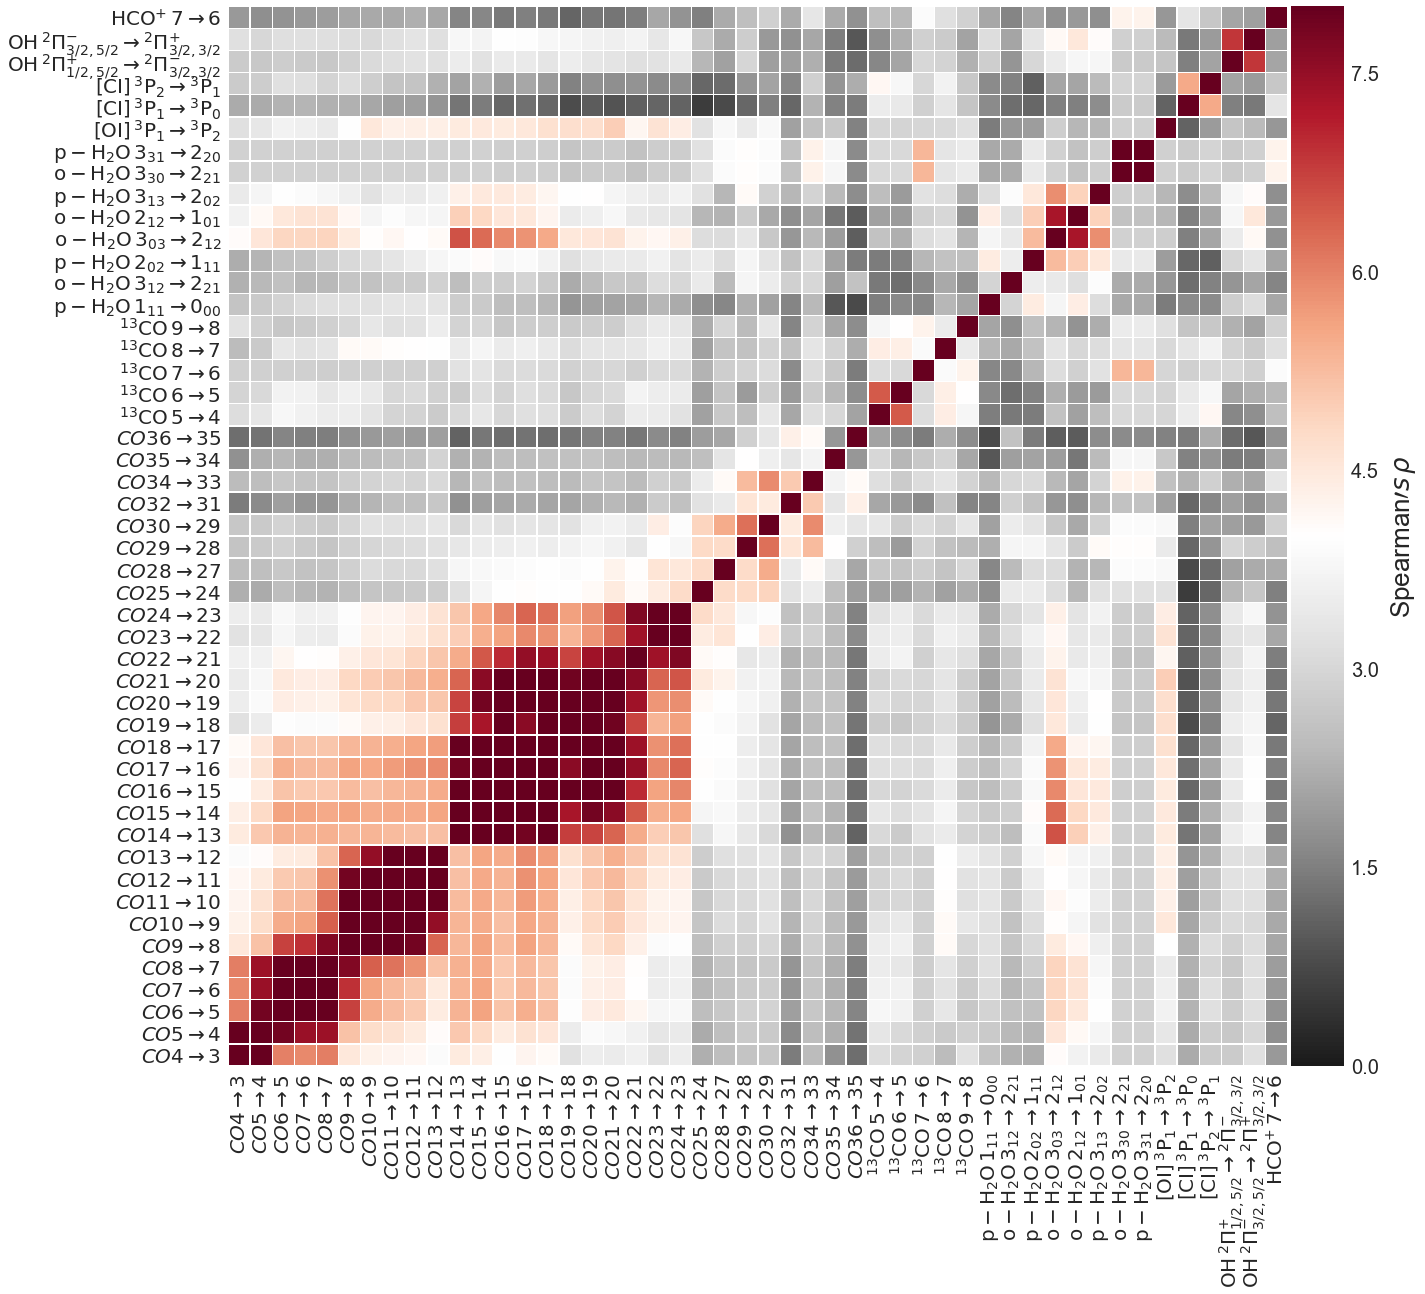

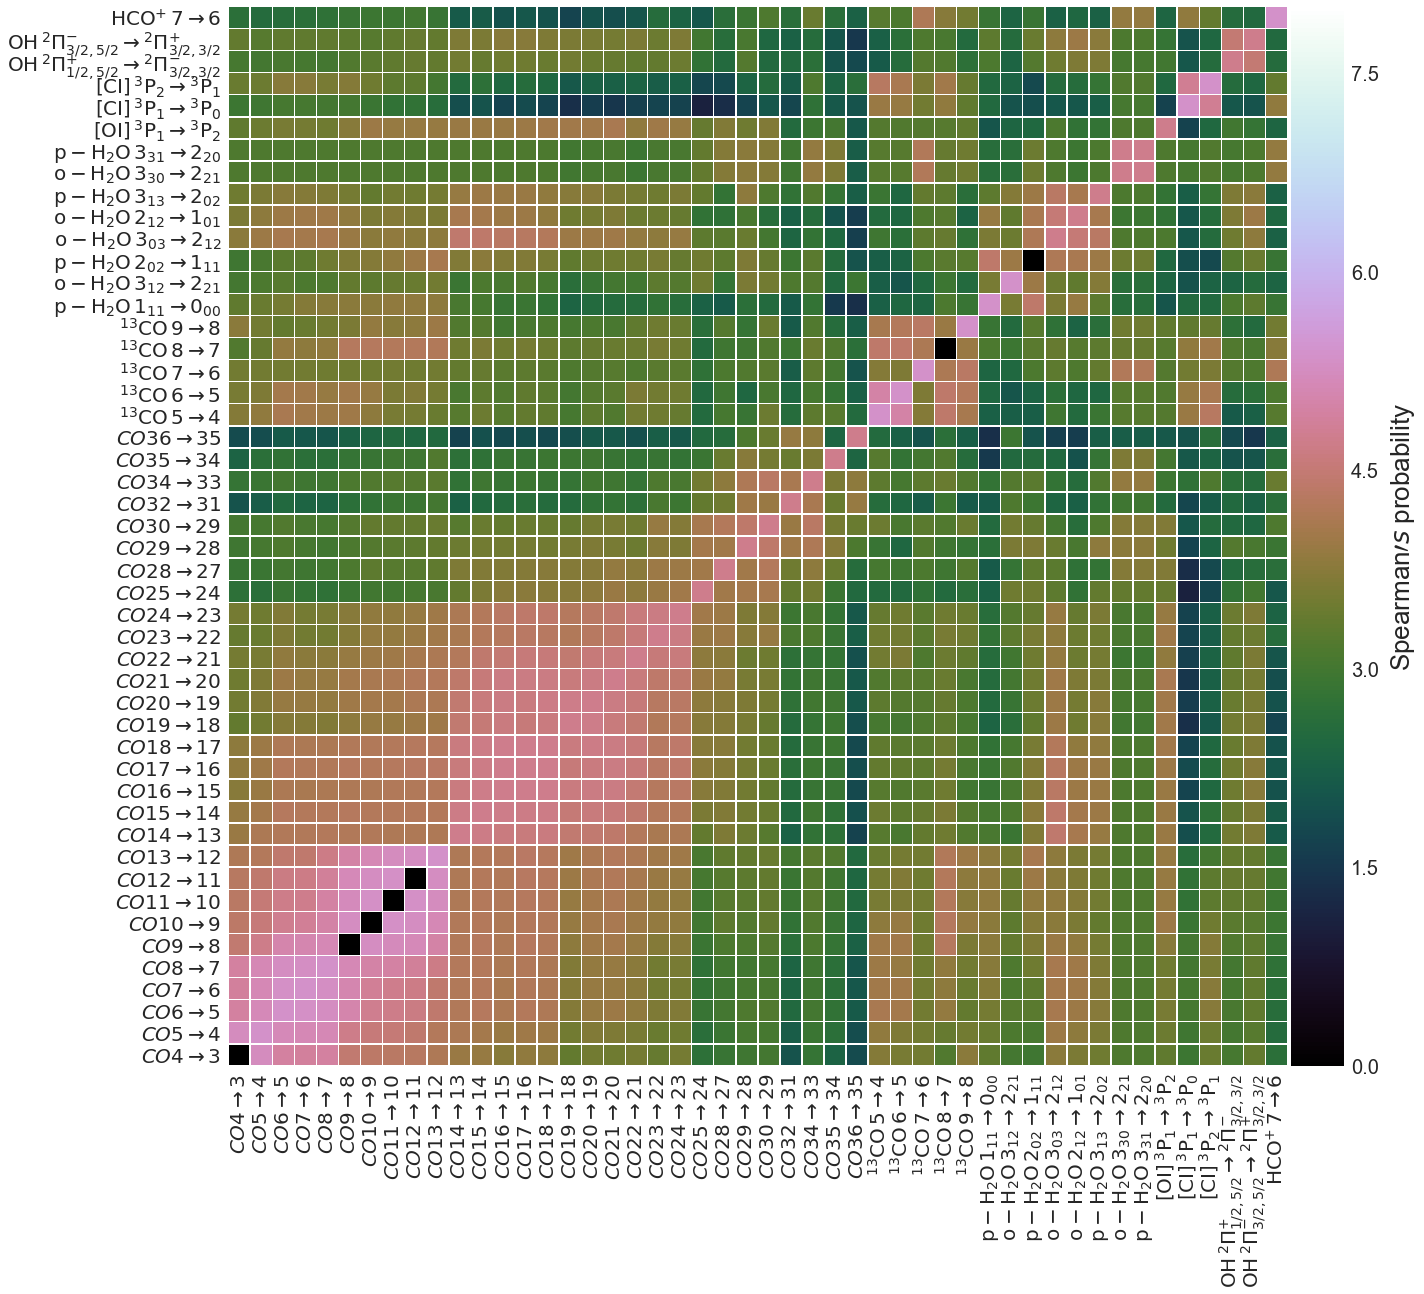

In [73]:
#wavelength sorter
# sorter = np.argsort(wave_list)
# all correlations
for i in range(len(col_name)):
    general_heatmap(line_list, col_name[i], corr_table, labels[i], line_labels=line_labels)

In [ ]:
mod_names = ['SSW','SLW','R1','B2B','B2A']
for mod in mod_names:
    for i in range(len(col_name)):
        general_heatmap(line_list[(wave_list >= module[mod][0]) & (wave_list < module[mod][1])],
                        col_name[i], corr_table, labels[i], mod_name=mod,
                        line_labels=line_labels[(wave_list >= module[mod][0]) & (wave_list < module[mod][1])])